In [1]:
#%matplotlib inline
%matplotlib notebook
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
from scipy.integrate import odeint

#### Plot layout
sns.set_style("ticks")
sns.set_context("notebook")
sns.set_palette("Set1")
plt.rcParams["figure.dpi"] = 100
plt.rcParams['text.usetex'] = False

## 06 1D Heat transfer coupled with cure model

_notebook by Nico Liebers (nico.liebers@dlr.de), Deutsches Zentrum für Luft- und Raumfahrt (DLR), 2019_

In this notebook we extend the 1D heat transfer model from lesson 04 by the cure model for RTM6 from lesson 01. As the cure of the resin is exotherm it releases heat which will act as a heat source in the heat equation. The cure rate itself depends on the temperature and the current degree of cure. 

The 1D heat equation is: 

$$
\frac{\partial T}{\partial t} = \alpha_x \frac{\partial^2 T}{\partial x^2} + s
$$

We will substitute the thermal diffusivity $\alpha_x$:

$$
\alpha = \frac{k}{c_p \cdot \varrho}
$$

After multiplying both sides by $c_p$ and redefining the source term as $q$: 

$$
c_p \frac{\partial T}{\partial t} = \frac{k_x}{\varrho} \frac{\partial^2 T}{\partial x^2} + q
$$

The heat source $q$ has the unit:

$$
[q] = \left[ c_p \frac{\partial T}{\partial t} \right] = 
\frac{J}{kg \cdot K} \frac{K}{s} = \frac{W}{kg}
$$

The heat released by the resin during curing is then calculated by: 

$$
q = (1 - \psi) H_r \frac{\partial X}{\partial t}
$$

$$
[q] = \frac{J}{kg} \frac{1}{s} = \frac{W}{kg}
$$


- $H_r$ - Reaction enthalpy released during cure $\left[ \frac{J}{kg} \right]$
- $\psi$ - Fiber mass fraction $\left[ - \right]$
    - As only the resin fraction produces heat we multipy by $(1 - \psi)$. 
    - The higher the fiber content the lower the released heat but the higher the thermal mass absorbing the heat. 

Finally the CFL stability criterion becomes:

$$
\begin{align}
 \Delta t  &\leq \frac{\Delta x^2}{2 \alpha} \\
\Delta t   &\leq \Delta x^2 \frac{c_p \varrho}{2 k}
\end{align}
$$

## Example: Heat transfer steel RTM tool

We will simulate the cure of a composite part in a RTM mold by a 1D model. The spatial descetiziation is in thickness direction. The mold and composite part are symmetrical, so it suffices to simulate half of composite part and one mold half.  

Other assumptions and simplifications are: 

- The section we simulate is far from edges so no heat flux apart of the thickness direction occurs. 


- There is no resin flow and we neglect volume shrinkage. 


- The fibers are equally distributed in the composite plies. 


- We keep the thermal properties independent from temperature and degree of cure (thermal heat capacity, thermal conductivity etc.).


- Material properties from different sources, not for exact same material. 


- Perfect control of outer mold temperature $T_0$ (set as boundary condition)


<img src="./figures/heat 1d model 03.png" width="500"/>

The steel mold has the following properties:

- Thickness $d_{mold} = 20 mm$

- Density $\varrho_{steel} = 7850 \frac{kg}{m^3}$

- Specific heat capacity $c_{p, steel} = 475 \frac{kg}{m^3}$

- Thermal conductivity $k_{steel} = 50 \frac{W}{m \cdot K}$

The composite part (fibers are perpendicular to heat transfer direction):

- Thickness $d_{comp} = 8 mm$

- Fiber volume fraction $\Phi = 0.6$

- Fibers (carbon): 

    - $\varrho_{f} = 1740 \frac{kg}{m^3}$

    - $c_{f} = 710 \frac{J}{kg \cdot K}$

    - $k_{f \perp} = 1.7 \frac{W}{m \cdot K}$

- Matrix (RTM6): 

    - $\varrho_{m} = 1110 \frac{kg}{m^3}$

    - $c_{m} = 1224 \frac{J}{kg \cdot K}$

    - $k_{f \perp} = 0.21 \frac{W}{m \cdot K}$

The cure model for RTM6 is the same as from lesson 01, with the reaction enthalpy: 

$H_r = 490 \cdot 10^3 \frac{J}{kg}$

For the model we will use a spatial discretization distance of: 

$\Delta x = 1 mm$

The total thickness is:

$d_{tot} = d_{mold} + \frac{d_{comp}}{2} = 24 mm$

### Calculate thermal composite properties

In [2]:
# first create steel properties
rho_steel = 7850
c_steel = 475
k_steel = 50

# composite properties
phi = .6
CF = dict(k_f_parallel=10,
          k_f_perp=1.7,
          rho_f=1700,
          c_f=710) 
EP = dict(k_m=.21,
          rho_m=1110,
          c_m=1224)
material_data = {**CF, **EP}

c_f = material_data["c_f"]
rho_f = material_data["rho_f"]
c_m = material_data["c_m"]
rho_m = material_data["rho_m"]
k_f_perp = material_data["k_f_perp"]
k_m = material_data["k_m"]

c_comp = (c_f * rho_f * phi + c_m * rho_m * (1 - phi)) / (rho_f * phi + rho_m * (1 - phi))
print("c_comp =", c_comp)

# k perpendicular to fibers
k_comp = 1 / (phi / k_f_perp * phi + (1 - phi) / k_m)
print("k_comp =", k_comp)

rho_comp = rho_f * phi + rho_m * (1 - phi)
print("rho_comp =", rho_comp)

psi_comp = rho_f * phi / (rho_f * phi + rho_m * (1 - phi))
print("psi_comp =", psi_comp)

c_comp = 865.8852459016393
k_comp = 0.47247220751720487
rho_comp = 1464.0
psi_comp = 0.6967213114754098


### Cure Model

In [3]:
def calc_X_max(temp, model_parameters): 
    """Calculate maximum attainable degree of cure depending on cure temperature"""
    a = model_parameters["a"]
    b = model_parameters["b"]
    return 1/(1+np.exp(-temp*a+b))
def arrhenius(A, E, T):
    """Calculate Arrhenius factor k"""
    return A*np.exp(-E / R / T)
def arrhenius_facors(temp, model_parameters):
    """Calculate both arrhenius factos k1 and k2 for temperature temp and the model"""
    T = temp + kelvin
    A1 = model_parameters["A1"]
    EA1 = model_parameters["EA1"]
    A2 = model_parameters["A2"]
    EA2 = model_parameters["EA2"]
    return arrhenius(A1, EA1, T), arrhenius(A2, EA2, T)
def reaction_model(X, temp, model_parameters):  
    """Calculate reaction rate, input function for numerical integration"""
    k1, k2 = arrhenius_facors(temp, model_parameters)
    max_X = calc_X_max(temp, model_parameters)
    m = model_parameters["m"]
    l = model_parameters["l"]
    n = model_parameters["n"]
    d_X = max_X - X
    d_X[d_X < 0] = 0
    return k1 * d_X**l + k2 * X**m * d_X**n
def interpol_tempcycle(t, cycle):
    """Return temperature at time t in cycle by linear interpolation"""
    return np.interp(t, cycle[:,0], cycle[:,1])


Hein_2018 = dict(Tg0=-16.8, Tg8=225, lam=.543,    # DiBenedetto
                a=.04, b=3.93,                    # X_max
                A1=np.exp(11.149), EA1=75549,     # Cure model parameters
                A2=np.exp(8.762), EA2=50911, 
                l=.489, m=1.549, n=2.179,
                Hr=490e3                         # Enthalpy [J / kg]
                )
#### Constants
kelvin = 273.15
R = 8.314472

### Discretize space

Nx = 24


<IPython.core.display.Javascript object>


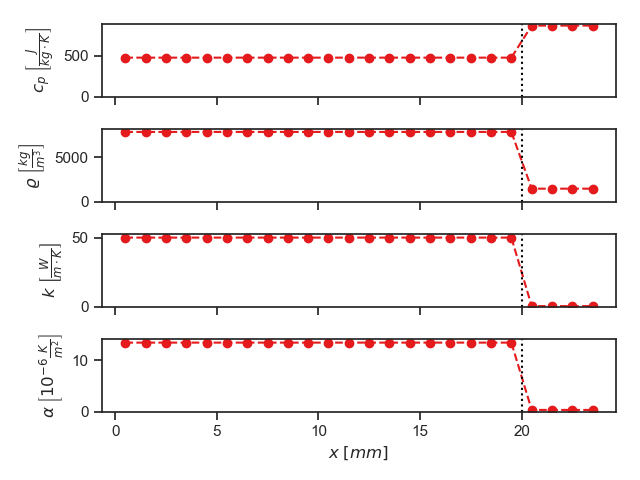

In [4]:
dx = 1/1000
d_mold = 20/1000
d_comp = 4/1000
Nx = int((d_mold + d_comp) / dx)
print("Nx =", Nx)

# shift coordinates half a step (element not material interface)
x = (np.arange(Nx) + .5) * dx  

# make indexes of materials (boolean arrays)
idx_mold = x <= d_mold
idx_comp = x > d_mold

# assign properties
cp = np.zeros(Nx)
cp[idx_mold] = c_steel
cp[idx_comp] = c_comp

rho = np.zeros(Nx)
rho[idx_mold] = rho_steel
rho[idx_comp] = rho_comp

k = np.zeros(Nx)
k[idx_mold] = k_steel
k[idx_comp] = k_comp

# plot model properties
fig, ax = plt.subplots(4, 1, sharex=True)
ax1, ax2, ax3, ax4 = ax

line_kw = dict(marker="o", ls="--")
plt.sca(ax1)
plt.plot(x*1000, cp, **line_kw)
plt.ylabel(r"$c_p \; \left[ \frac{J}{kg \cdot K} \right]$")
plt.sca(ax2)
plt.plot(x*1000, rho, **line_kw)
plt.ylabel(r"$\varrho \; \left[ \frac{kg}{m^3} \right]$")
plt.sca(ax3)
plt.plot(x*1000, k, **line_kw)
plt.ylabel(r"$k \; \left[ \frac{W}{m \cdot K} \right]$")
plt.sca(ax4)
plt.plot(x*1000, k/cp/rho*1e6, **line_kw)
plt.ylabel(r"$\alpha \; \left[ 10^{-6} \frac{K}{m^2} \right]$")
plt.xlabel(r"$x \; [mm]$");

for _ax in ax:
    # plot mold - composite part - interface
    _ax.axvline(d_mold*1000, ls=":", color="k")
    _ax.set_ylim((0, None))
plt.tight_layout()

### Time discretization

In [5]:
# CFL criterion
dt = dx**2 * np.min(cp * rho / 2 / k)
print("limit for numerical stability: dt =", dt, "s")
dt *= .8
print("used time step: dt =", dt, "s")

t_max = 3*3600
print("t_max =", t_max)
Nt = int(t_max / dt + 1) 
print("Nt =", Nt)
t = np.arange(Nt) * dt

# Set temperature cycle
T_cure = 160
cycle = [[0, T_cure]]
cycle.append([t_max, T_cure]) 
cycle = np.array(cycle)

limit for numerical stability: dt = 0.0372875 s
used time step: dt = 0.029830000000000002 s
t_max = 10800
Nt = 362052


### Simulate!

i_snap = 1206


<IPython.core.display.Javascript object>


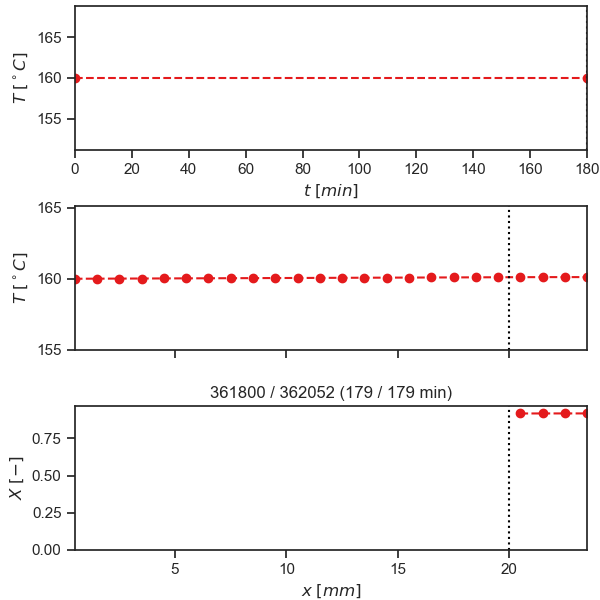

In [6]:
# Set initial conditions
T = np.zeros(Nx)
T[:] = cycle[0, 1]

# degree of cure
X = np.zeros(np.sum(idx_comp))

# choose how often to update plot
i_snap = Nt // 300
print("i_snap =", i_snap)

### prepare output arrays
# 1st column: max temp and X in composite
# 2nd column: min temp and X in composite
# 3rd column: temp and X at mold interface of composite
# 4th column: temp and X at middle of composite (border of simulation)
T_out = np.zeros((Nt, 4))
X_out = np.zeros((Nt, 4))

# prepare plot
fig, ax = plt.subplots(3, 1, figsize=[6, 6])
ax1, ax2, ax3 = ax

plt.sca(ax1)
plt.xlabel(r"$t \; [min]$")
plt.ylabel(r"$T \; [ ^\circ C ]$")
plt.plot(cycle[:, 0]/60, cycle[:, 1], **line_kw)
p_cycle = plt.axvline(cycle[0, 0]/60, ls=":", color="k")

plt.sca(ax2)
plt.ylabel(r"$T \; [ ^\circ C ]$")
p_temp, = plt.plot(x*1000, T, **line_kw)

plt.sca(ax3)
plt.ylabel(r"$X \; [ - ]$")
p_cure, = plt.plot(x[idx_comp]*1000, X, **line_kw)
plt.xlabel(r"$x \; [mm]$")
for _ax in ax[1:]:
    # plot mold - composite part - interface    
    _ax.axvline(d_mold*1000, ls=":", color="k")
    
ax1.autoscale(axis="x", tight=True)
ax2.autoscale(axis="x", tight=True)
ax3.set_xlim(ax2.get_xlim())
ax2.set_xticklabels([])

plt.tight_layout(pad=0)
plt.ion();

In [7]:
sigma = k[1:-1] / rho[1:-1] / cp[1:-1] * dt / dx**2
for n in range(Nt):
    # Left Boundary: set value from temperate cycle 
    T[0] = interpol_tempcycle(t[n], cycle)
    
    # calculate heat transfer
    T[1:-1] = (T[1:-1] +
               sigma * (T[2:] - 2 * T[1:-1] + T[:-2]))
    
    # reaction rate
    dXdt = reaction_model(X, T[idx_comp], Hein_2018)
    # update degree of cure
    X += dXdt*dt
    
    # released heat
    q = dXdt*dt*Hein_2018["Hr"]*(1-psi_comp)    
    T[idx_comp] += q/cp[idx_comp]
    
    # right boundary condition (no heat flux)
    T[-1] = T[-2]
    
    # write output
    T_out[n, 0] = T[idx_comp].max()
    T_out[n, 1] = T[idx_comp].min()
    T_out[n, 2] = T[idx_comp][0]
    T_out[n, 3] = T[idx_comp][-1]
    X_out[n, 0] = X.max()
    X_out[n, 1] = X.min()
    X_out[n, 2] = X[0]
    X_out[n, 3] = X[-1]    
    
    # update plot
    if n % i_snap == 0:
        ax3.set_title("%d / %d (%d / %d min)" %(n, Nt, t[n]/60, t[-1]/60))
        p_cycle.set_xdata(t[n]/60)
        p_temp.set_ydata(T)
        p_cure.set_ydata(X)      
        ax2.set_ylim((T.min()-5, T.max()+5))
        ax3.set_ylim((0, X.max()+.05))
        fig.canvas.draw()

### Postprocessing

T_max = 174.99092630634075


<IPython.core.display.Javascript object>


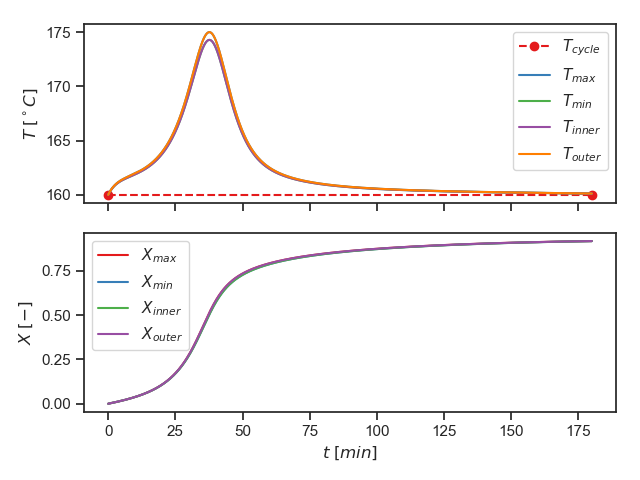

In [8]:
print("T_max =", T_out[:, 0].max())

fig, ax = plt.subplots(2, 1, sharex=True)
ax1, ax2 = ax
ax1.plot(cycle[:, 0]/60, cycle[:, 1], "o--", label=r"$T_{cycle}$")

for i, _label in enumerate(["max", "min", "inner", "outer"]):
    plt.sca(ax1)
    label = r"$T_{%s}$" %_label
    plt.plot(t/60, T_out[:, i], label=label)
    plt.sca(ax2)
    label = r"$X_{%s}$" %_label
    plt.plot(t/60, X_out[:, i], label=label)

for _ax in ax:
    _ax.legend()

ax1.set_ylabel(r"$T \; [ ^\circ C ]$")
ax2.set_ylabel(r"$X \; [ - ]$")
ax2.set_xlabel(r"$t \; [min]$")
plt.tight_layout();